## Prepare and Data load

In [1]:
import pickle
import gc
import re
import itertools
import json
from pathlib import Path

from tqdm.auto import tqdm
import shap
import lime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from PIL import Image

In [53]:
pd.set_option("max_columns", 300)

In [2]:
data_dir = Path("../data/train_result")

In [3]:
np.random.seed(2020)

In [4]:
def read_pickle(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data

In [5]:
models = read_pickle(data_dir / "models.pkl")
use_feats = read_pickle(data_dir / "use_feats.pkl")
val_preds = read_pickle(data_dir / "val_preds.pkl")
importances = read_pickle(data_dir / "importances.pkl")

In [6]:
df = pd.read_pickle(data_dir / "df.pkl")

In [7]:
ohe_targets = pd.read_pickle(data_dir / "ohe_targets.pkl")

In [8]:
# trainとvalid分けて保存すべきだったのに忘れていたため、train_lightgbm.pyと同じ分割をする
train_df, valid_df, train_y, valid_y = train_test_split(df, ohe_targets, test_size=0.2, shuffle=True, random_state=2020)

In [9]:
del df, train_df
gc.collect()

60

In [10]:
use_feats

['bakaze',
 'kyoku_num',
 'honba',
 'kyotaku',
 'parent',
 'riichi_player',
 'player0_point',
 'player1_point',
 'player2_point',
 'player3_point',
 'dora_num',
 'sutehai_num',
 'sutehai_jihai_rate',
 'sutehai_yaochu_rate',
 'sutehai_456_rate',
 'sengen_hai',
 'sengen_hai_number',
 'sengen_hai_color',
 'sengen_hai_count',
 'sutehai_dora_sum',
 'ratio_not_yaochu_in_first3',
 'ratio_not_yaochu_in_first6',
 'ratio_456_in_first3',
 'ratio_456_in_first6',
 'discard_1',
 'discard_2',
 'discard_3',
 'discard_4',
 'discard_5',
 'discard_6',
 'discard_7',
 'discard_8',
 'discard_9',
 'discard_11',
 'discard_12',
 'discard_13',
 'discard_14',
 'discard_15',
 'discard_16',
 'discard_17',
 'discard_18',
 'discard_19',
 'discard_21',
 'discard_22',
 'discard_23',
 'discard_24',
 'discard_25',
 'discard_26',
 'discard_27',
 'discard_28',
 'discard_29',
 'discard_31',
 'discard_32',
 'discard_33',
 'discard_34',
 'discard_35',
 'discard_36',
 'discard_37',
 'can_see_count_1',
 'can_see_count_2',
 'can_see_count_3',
 'can_see_count_4',
 'can_see_count_5',
 'can_see_count_6',
 'can_see_count_7',
 'can_see_count_8',
 'can_see_count_9',
 'can_see_count_11',
 'can_see_count_12',
 'can_see_count_13',
 'can_see_count_14',
 'can_see_count_15',
 'can_see_count_16',
 'can_see_count_17',
 'can_see_count_18',
 'can_see_count_19',
 'can_see_count_21',
 'can_see_count_22',
 'can_see_count_23',
 'can_see_count_24',
 'can_see_count_25',
 'can_see_count_26',
 'can_see_count_27',
 'can_see_count_28',
 'can_see_count_29',
 'can_see_count_31',
 'can_see_count_32',
 'can_see_count_33',
 'can_see_count_34',
 'can_see_count_35',
 'can_see_count_36',
 'can_see_count_37',
 'manzu_ratio',
 'pinzu_ratio',
 'souzu_ratio',
 'jihai_ratio',
 'manzu_ratio_first6',
 'pinzu_ratio_first6',
 'souzu_ratio_first6',
 'jihai_ratio_first6',
 'manzu_first_hai',
 'pinzu_first_hai',
 'souzu_first_hai',
 'jihai_first_hai',
 'manzu_second_hai',
 'pinzu_second_hai',
 'souzu_second_hai',
 'manzu_diff_first_second',
 'pinzu_diff_first_second',
 'souzu_diff_first_second',
 'manzu_last_hai',
 'pinzu_last_hai',
 'souzu_last_hai',
 'manzu_last2_hai',
 'pinzu_last2_hai',
 'souzu_last2_hai',
 'manzu_diff_last_last2',
 'pinzu_diff_last_last2',
 'souzu_diff_last_last2',
 'manzu_suji14',
 'pinzu_suji14',
 'souzu_suji14',
 'manzu_suji25',
 'pinzu_suji25',
 'souzu_suji25',
 'manzu_suji36',
 'pinzu_suji36',
 'souzu_suji36',
 'manzu_suji47',
 'pinzu_suji47',
 'souzu_suji47',
 'manzu_suji58',
 'pinzu_suji58',
 'souzu_suji58',
 'manzu_suji69',
 'pinzu_suji69',
 'souzu_suji69',
 'sute_suji_num',
 'manzu_first3_hai_order_encode',
 'pinzu_first3_hai_order_encode',
 'souzu_first3_hai_order_encode',
 'manzu_last3_hai_order_encode',
 'pinzu_last3_hai_order_encode',
 'souzu_last3_hai_order_encode']

In [11]:
valid_df.head()

,bakaze,kyoku_num,honba,kyotaku,dora,parent,riichi_player,agari_hai,player0_sutehai,player0_point,...,manzu_suji69,pinzu_suji69,souzu_suji69,sute_suji_num,manzu_first3_hai_order_encode,pinzu_first3_hai_order_encode,souzu_first3_hai_order_encode,manzu_last3_hai_order_encode,pinzu_last3_hai_order_encode,souzu_last3_hai_order_encode
316443,0,4,0,0,[9],3,0,"[4, 5, 7]","[34, 19, 18, 1, 3, 3, 33, 1, 8, 22, 18, 33, 29...",131,...,0,1,1,10,NaN,NaN,-1.0,NaN,NaN,-1.0
48368,0,3,1,1,[7],2,2,"[24, 26, 27]","[35, 34, 22, 3, 4, 15, 23, 2, 19, 7, 17, 36, 9...",382,...,1,1,1,12,NaN,NaN,NaN,NaN,NaN,NaN
231712,0,1,2,1,[4],0,3,"[13, 16]","[9, 36, 12, 19, 17, 34, 28, 15, 27, 32, 33, 7,...",235,...,1,1,0,10,NaN,NaN,NaN,NaN,NaN,NaN
489372,1,3,1,0,[4],2,1,"[4, 7]","[33, 32, 36, 33, 1, 2, 28, 21, 17, 12, 24]",131,...,0,0,0,7,-1.0,-1.0,NaN,-1.0,-1.0,NaN
1830734,0,1,0,0,[3],0,0,"[3, 6]","[34, 9, 31, 32, 35, 3, 25, 19, 36, 31, 17, 18,...",250,...,1,1,0,8,-1.0,NaN,-1.0,-1.0,NaN,-1.0


In [12]:
tmp = importances[importances.hai == 1][["feature", "gain"]].sort_values("gain", ascending=False).iloc[:30].reset_index(drop=True)
tmp = tmp.set_index("feature")
print(tmp.to_markdown())
tmp

| feature                       |      gain |
|:------------------------------|----------:|
| manzu_suji14                  | 428518    |
| discard_1                     | 246415    |
| manzu_first_hai               |  53528    |
| sengen_hai                    |  42191.8  |
| sute_suji_num                 |  40264.3  |
| discard_2                     |  35750    |
| manzu_ratio_first6            |  29590.7  |
| discard_4                     |  29198    |
| manzu_ratio                   |  18617.2  |
| discard_3                     |  18063.7  |
| can_see_count_1               |  12186.1  |
| can_see_count_2               |   9478.43 |
| manzu_second_hai              |   9232.62 |
| sutehai_yaochu_rate           |   7794.8  |
| ratio_456_in_first6           |   6770.15 |
| player0_point                 |   6616.69 |
| manzu_last_hai                |   6178.87 |
| sutehai_num                   |   5963.82 |
| sengen_hai_number             |   5644.4  |
| manzu_diff_first_second       | 

,gain
feature,
manzu_suji14,428517.598258
discard_1,246414.826833
manzu_first_hai,53528.005558
sengen_hai,42191.839851
sute_suji_num,40264.304112
discard_2,35750.009269
manzu_ratio_first6,29590.715133
discard_4,29197.982913
manzu_ratio,18617.167857


In [13]:
tmp = importances[importances.hai == 32][["feature", "gain"]].sort_values("gain", ascending=False).iloc[:20].reset_index(drop=True)
tmp = tmp.set_index("feature")
print(tmp.to_markdown())
tmp

| feature                    |      gain |
|:---------------------------|----------:|
| can_see_count_32           | 359076    |
| discard_32                 |  84561    |
| sute_suji_num              |  19852.3  |
| sutehai_num                |   8081.86 |
| bakaze                     |   6031.25 |
| ratio_not_yaochu_in_first3 |   4031.93 |
| player0_point              |   2902.47 |
| jihai_first_hai            |   2767.41 |
| jihai_ratio_first6         |   2365.44 |
| dora_num                   |   2241.72 |
| sengen_hai                 |   2138.46 |
| player1_point              |   1929.55 |
| player3_point              |   1928.33 |
| sengen_hai_count           |   1693.06 |
| sutehai_yaochu_rate        |   1466.89 |
| player2_point              |   1435.81 |
| jihai_ratio                |   1189.01 |
| souzu_ratio                |   1181.95 |
| can_see_count_1            |   1167.43 |
| manzu_ratio                |   1109.77 |


,gain
feature,
can_see_count_32,359075.929157
discard_32,84560.954360
sute_suji_num,19852.298362
sutehai_num,8081.856347
bakaze,6031.251645
ratio_not_yaochu_in_first3,4031.930071
player0_point,2902.473893
jihai_first_hai,2767.412814
jihai_ratio_first6,2365.435525


In [16]:
valid_df.reset_index(drop=True, inplace=True)

In [15]:
val_preds.shape, valid_y.shape

((882487, 34), (882487, 34))

## LogLoss

In [17]:
def make_baseline_pred(valid_df):
    def baseline_map_func(hai_list):
        atarihai_arr = np.eye(38)[hai_list].max(axis=0)
        kiken_arr = 1 - atarihai_arr
        kiken_arr = kiken_arr  / kiken_arr.sum() * 1.8
        use_index = list(range(1, 10)) + list(range(11, 20)) + list(range(21, 30)) + list(range(31, 38))
        kiken_arr = kiken_arr[use_index]
        return kiken_arr
    
    baseline_pred = valid_df["player0_sutehai"].map(baseline_map_func)
    baseline_pred = np.vstack(baseline_pred.tolist())
    return baseline_pred

In [18]:
valid_df["agari_hai"].map(len).mean()

1.8461155801728524

In [19]:
baseline_pred = make_baseline_pred(valid_df)

In [20]:
log_loss(valid_y, baseline_pred)

6.316280441806053

In [21]:
log_loss(valid_y, val_preds)

5.665440754871881

# 個別事例

In [22]:
sutehai_srs = valid_df["player0_sutehai"]
sutehai_srs1 = valid_df["player1_sutehai"]
sutehai_srs2 = valid_df["player2_sutehai"]
sutehai_srs3 = valid_df["player3_sutehai"]

In [23]:
tehai_srs = valid_df["player1_tehai"]

In [24]:
def get_hai_path(h):
    img_dir_path = Path("../hai-images/")
    if h < 10:
        f_str = f"man{h}"
    elif h < 20:
        f_str = f"pin{h%10}"
    elif h < 30:
        f_str = f"sou{h%10}"
    else:
        if h == 35:
            h = 36
        elif h == 36:
            h = 35
        f_str = f"ji{h%10}"
    filepath = str(img_dir_path / f"{f_str}-66-90-s.png")
    return filepath

In [25]:
def show_hai_images(hai_list, riichi=True):
    images = [Image.open(get_hai_path(h)) for h in hai_list]
    fig = plt.figure(figsize =(5, 5))
    for i, image in enumerate(images):
        ax = plt.subplot(5, 6, i+1)
        if i == len(images) - 1 and riichi:
            image = image.rotate(90, expand=True)
        ax.imshow(image, resample=True)
        ax.axis("off")
    plt.show()

In [26]:
def show_tehai(hai_list):
    images = [Image.open(get_hai_path(h)) for h in hai_list]
    fig = plt.figure(figsize =(5, 5))
    for i, image in enumerate(images):
        ax = plt.subplot(5, 18, i+1)
        ax.imshow(image, resample=True)
        ax.axis("off")
    plt.show()

In [27]:
def show_pred_img(pred_arr):
    all_hai_list = list(range(1, 10)) + list(range(11, 20)) + list(range(21, 30)) + list(range(31, 38))
    images = [Image.open(get_hai_path(h)) for h in all_hai_list]
    fig = plt.figure(figsize =(8, 8))
    for i, image in enumerate(images):
        ax = fig.add_subplot(5, 9, i+1)
        fig.subplots_adjust(top = 0.6, hspace = 0.6)
        ax.imshow(image)
        ax.set_title(str(round(pred_arr[i],4)), y=-0.5)
        ax.axis("off")

## Shap Value prepare

In [28]:
explainers = {}
for model_i in tqdm(models.keys()):
    explainers[model_i] = shap.TreeExplainer(models[model_i])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [65]:
explainers.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37])

In [29]:
shap.initjs()

## LIME prepare

In [30]:
def visualize_instance_html_japanese(self, exp, label, div_name, exp_object_name,
                                text=True, opacity=True):
    if not text:
        return u''
    text = (self.indexed_string.raw_string()
            .encode('utf-8', 'xmlcharrefreplace').decode())
    text = re.sub(r'[<>&]', '|', text)
    exp = [(self.indexed_string.word(x[0]),
            self.indexed_string.string_position(x[0]),
            x[1]) for x in exp]
    all_ocurrences = list(itertools.chain.from_iterable(
        [itertools.product([x[0]], x[1], [x[2]]) for x in exp]))
    all_ocurrences = [(x[0], int(x[1]), x[2]) for x in all_ocurrences]
    ret = '''
        %s.show_raw_text(%s, %d, %s, %s, %s);
        ''' % (exp_object_name, json.dumps(all_ocurrences), label,
               json.dumps(text), div_name, json.dumps(opacity))
    return ret

## 実例

In [32]:
def print_example(ix):
    print("="*30)
    print("立直者の捨て牌")
    print("="*30)
    show_hai_images(sutehai_srs.iloc[ix])

    """
    print("="*30)
    print("自身（上家）の捨て牌")
    print("="*30)
    show_hai_images(sutehai_srs1.iloc[ix], riichi=False)


    print("="*30)
    print("立直者の対面の捨て牌")
    print("="*30)
    show_hai_images(sutehai_srs2.iloc[ix], riichi=False)


    print("="*30)
    print("立直者の下家の捨て牌")
    print("="*30)
    show_hai_images(sutehai_srs3.iloc[ix], riichi=False)

    """

    print("="*30)
    print("予測結果")
    print("="*30)
    show_pred_img(val_preds[ix])

立直者の捨て牌


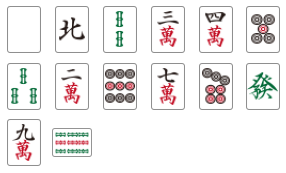

予測結果


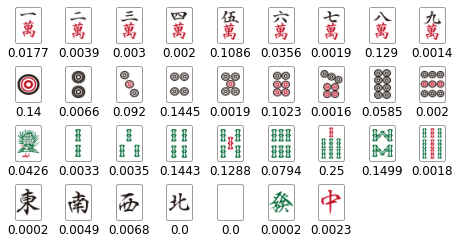

In [33]:
print_example(1)

- マンズは全体的に安全そう。とはいえ、5-8マンは全然ありうる。
- ピンズは最初に5ピンが切られて、かつ上の方の牌だけ切られていることから、1-4ピンだけ危なく、6ピン, 8ピンは割と大丈夫そう
- ソウズは最初に2ソウ, 3ソウと切られているので1-4ソウはマシそう。4-7ソウ、5-8ソウはかなり危険。
- 特に宣言牌が9ソウなことから、「779」「889」「799」「899」からの9切りによる、7ソウ、8ソウの待ちもありかなり危険

In [35]:
print(valid_y.iloc[1])

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
21    0.0
22    0.0
23    0.0
24    1.0
25    0.0
26    1.0
27    1.0
28    0.0
29    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
Name: 48368, dtype: float64


立直者の捨て牌


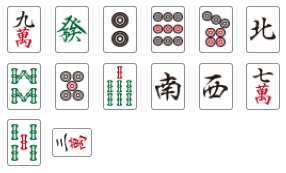

予測結果


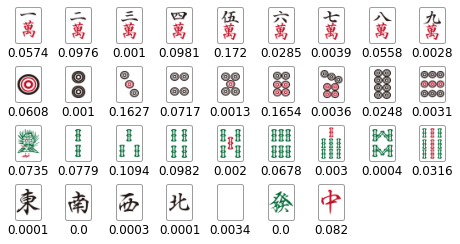

In [36]:
print_example(2)

- マンズは1-4マン、2-5マン、5-8マンどれも危ない。宣言牌周りの1-4, 2-5のほうが危険そう
- ピンズは序盤の2, 9, 7ピン切りから、3-6ピンだけ危険そう
- ソウズは最後の5ソウ周りの3-6ソウ危険、1-4ソウも危なそう

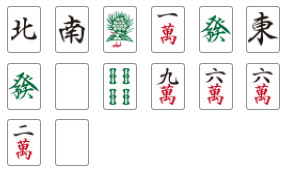

In [37]:
show_hai_images(sutehai_srs1.iloc[2], riichi=False)

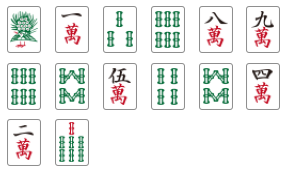

In [38]:
show_hai_images(sutehai_srs2.iloc[2], riichi=False)

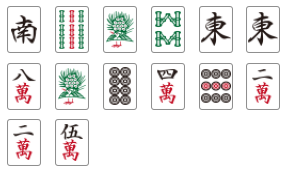

In [39]:
show_hai_images(sutehai_srs3.iloc[2], riichi=False)

In [40]:
tmp = tehai_srs.iloc[2]
print(tmp[:9])
print(tmp[9:18])
print(tmp[18:27])
print(tmp[27:])

[0, 0, 0, 1, 1, 1, 0, 2, 0]
[0, 0, 1, 1, 2, 1, 0, 0, 2]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [41]:
print(valid_y.iloc[2])

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
11    0.0
12    0.0
13    1.0
14    0.0
15    0.0
16    1.0
17    0.0
18    0.0
19    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
Name: 231712, dtype: float64


立直者の捨て牌


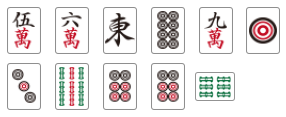

予測結果


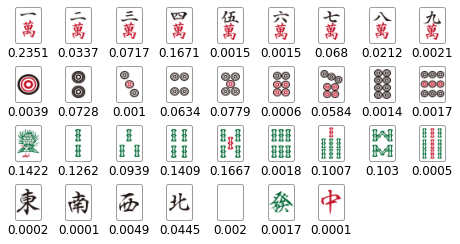

In [42]:
print_example(34)

In [43]:
print(valid_y.iloc[34])

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    1.0
16    0.0
17    0.0
18    0.0
19    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
Name: 4046081, dtype: float64


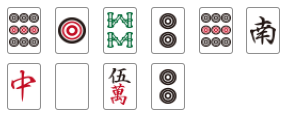

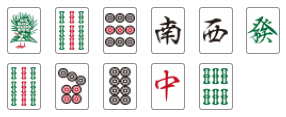

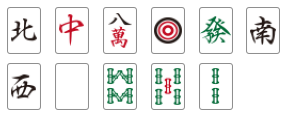

In [46]:
show_hai_images(sutehai_srs1.iloc[34], riichi=False)
show_hai_images(sutehai_srs2.iloc[34], riichi=False)
show_hai_images(sutehai_srs3.iloc[34], riichi=False)

In [49]:
valid_df.iloc[34]["dora"]

[3]

In [57]:
valid_df.iloc[34:35]

,bakaze,kyoku_num,honba,kyotaku,dora,parent,riichi_player,agari_hai,player0_sutehai,player0_point,player1_tehai,player1_sutehai,player1_point,player2_sutehai,player2_point,player3_sutehai,player3_point,dora_num,sutehai_num,sutehai_jihai_rate,sutehai_yaochu_rate,sutehai_456_rate,sengen_hai,sengen_hai_number,sengen_hai_color,sengen_hai_count,sutehai_dora_sum,ratio_not_yaochu_in_first3,ratio_not_yaochu_in_first6,ratio_456_in_first3,ratio_456_in_first6,discard_1,discard_2,discard_3,discard_4,discard_5,discard_6,discard_7,discard_8,discard_9,discard_11,discard_12,discard_13,discard_14,discard_15,discard_16,discard_17,discard_18,discard_19,discard_21,discard_22,discard_23,discard_24,discard_25,discard_26,discard_27,discard_28,discard_29,discard_31,discard_32,discard_33,discard_34,discard_35,discard_36,discard_37,can_see_count_1,can_see_count_2,can_see_count_3,can_see_count_4,can_see_count_5,can_see_count_6,can_see_count_7,can_see_count_8,can_see_count_9,can_see_count_11,can_see_count_12,can_see_count_13,can_see_count_14,can_see_count_15,can_see_count_16,can_see_count_17,can_see_count_18,can_see_count_19,can_see_count_21,can_see_count_22,can_see_count_23,can_see_count_24,can_see_count_25,can_see_count_26,can_see_count_27,can_see_count_28,can_see_count_29,can_see_count_31,can_see_count_32,can_see_count_33,can_see_count_34,can_see_count_35,can_see_count_36,can_see_count_37,manzu_ratio,pinzu_ratio,souzu_ratio,jihai_ratio,manzu_ratio_first6,pinzu_ratio_first6,souzu_ratio_first6,jihai_ratio_first6,manzu_first_hai,pinzu_first_hai,souzu_first_hai,jihai_first_hai,manzu_second_hai,pinzu_second_hai,souzu_second_hai,manzu_diff_first_second,pinzu_diff_first_second,souzu_diff_first_second,manzu_last_hai,pinzu_last_hai,souzu_last_hai,manzu_last2_hai,pinzu_last2_hai,souzu_last2_hai,manzu_diff_last_last2,pinzu_diff_last_last2,souzu_diff_last_last2,manzu_suji14,pinzu_suji14,souzu_suji14,manzu_suji25,pinzu_suji25,souzu_suji25,manzu_suji36,pinzu_suji36,souzu_suji36,manzu_suji47,pinzu_suji47,souzu_suji47,manzu_suji58,pinzu_suji58,souzu_suji58,manzu_suji69,pinzu_suji69,souzu_suji69,sute_suji_num,manzu_first3_hai_order_encode,pinzu_first3_hai_order_encode,souzu_first3_hai_order_encode,manzu_last3_hai_order_encode,pinzu_last3_hai_order_encode,souzu_last3_hai_order_encode
34,1,1,1,0,[3],0,2,[15],"[5, 6, 31, 18, 9, 11, 13, 29, 16, 16, 26]",244,"[0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, ...","[19, 11, 28, 12, 19, 32, 37, 35, 5, 12]",238,"[21, 29, 19, 32, 33, 36, 29, 17, 18, 37, 26]",164,"[34, 37, 8, 11, 36, 32, 33, 35, 28, 25, 22]",354,1,11,0.090909,0.363636,0.454545,26,6,2,0.034721,0,0.666667,0.5,0.666667,0.333333,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,3.0,2.0,1.0,0.0,0.0,2.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,3.0,1.0,3.0,2.0,1.0,2.0,2.0,3.0,1.818182,6.727273,5.0,2.818182,3.333333,4.833333,0.0,5.166667,5,18,29,31,6,11,26,1,7,3,9,16,26,6,16,29,3,0,3,0,1,0,1,0,0,1,1,1,0,0,0,1,1,0,1,1,1,10,NaN,NaN,-1.0,NaN,NaN,-1.0


In [44]:
importances[importances.hai == 2].sort_values("gain", ascending=False).iloc[:10]

,feature,gain,hai
25,discard_2,426055.142857,2
122,manzu_suji25,196601.528793,2
100,manzu_first_hai,66835.563162,2
26,discard_3,60826.290426,2
137,sute_suji_num,35027.590531,2
28,discard_5,34005.805090,2
15,sengen_hai,31663.331709,2
27,discard_4,18212.516814,2
96,manzu_ratio_first6,11895.182182,2
29,discard_6,11620.632553,2


立直者の捨て牌


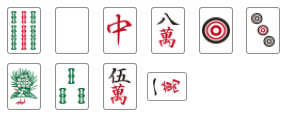

予測結果


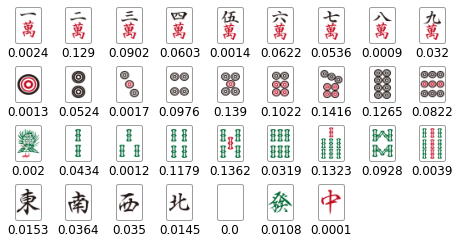

In [70]:
print_example(22)

In [62]:
valid_df.loc[22:22]

,bakaze,kyoku_num,honba,kyotaku,dora,parent,riichi_player,agari_hai,player0_sutehai,player0_point,player1_tehai,player1_sutehai,player1_point,player2_sutehai,player2_point,player3_sutehai,player3_point,dora_num,sutehai_num,sutehai_jihai_rate,sutehai_yaochu_rate,sutehai_456_rate,sengen_hai,sengen_hai_number,sengen_hai_color,sengen_hai_count,sutehai_dora_sum,ratio_not_yaochu_in_first3,ratio_not_yaochu_in_first6,ratio_456_in_first3,ratio_456_in_first6,discard_1,discard_2,discard_3,discard_4,discard_5,discard_6,discard_7,discard_8,discard_9,discard_11,discard_12,discard_13,discard_14,discard_15,discard_16,discard_17,discard_18,discard_19,discard_21,discard_22,discard_23,discard_24,discard_25,discard_26,discard_27,discard_28,discard_29,discard_31,discard_32,discard_33,discard_34,discard_35,discard_36,discard_37,can_see_count_1,can_see_count_2,can_see_count_3,can_see_count_4,can_see_count_5,can_see_count_6,can_see_count_7,can_see_count_8,can_see_count_9,can_see_count_11,can_see_count_12,can_see_count_13,can_see_count_14,can_see_count_15,can_see_count_16,can_see_count_17,can_see_count_18,can_see_count_19,can_see_count_21,can_see_count_22,can_see_count_23,can_see_count_24,can_see_count_25,can_see_count_26,can_see_count_27,can_see_count_28,can_see_count_29,can_see_count_31,can_see_count_32,can_see_count_33,can_see_count_34,can_see_count_35,can_see_count_36,can_see_count_37,manzu_ratio,pinzu_ratio,souzu_ratio,jihai_ratio,manzu_ratio_first6,pinzu_ratio_first6,souzu_ratio_first6,jihai_ratio_first6,manzu_first_hai,pinzu_first_hai,souzu_first_hai,jihai_first_hai,manzu_second_hai,pinzu_second_hai,souzu_second_hai,manzu_diff_first_second,pinzu_diff_first_second,souzu_diff_first_second,manzu_last_hai,pinzu_last_hai,souzu_last_hai,manzu_last2_hai,pinzu_last2_hai,souzu_last2_hai,manzu_diff_last_last2,pinzu_diff_last_last2,souzu_diff_last_last2,manzu_suji14,pinzu_suji14,souzu_suji14,manzu_suji25,pinzu_suji25,souzu_suji25,manzu_suji36,pinzu_suji36,souzu_suji36,manzu_suji47,pinzu_suji47,souzu_suji47,manzu_suji58,pinzu_suji58,souzu_suji58,manzu_suji69,pinzu_suji69,souzu_suji69,sute_suji_num,manzu_first3_hai_order_encode,pinzu_first3_hai_order_encode,souzu_first3_hai_order_encode,manzu_last3_hai_order_encode,pinzu_last3_hai_order_encode,souzu_last3_hai_order_encode
22,1,1,0,0,[9],0,3,[3],"[29, 35, 37, 8, 11, 13, 21, 23, 5, 1]",150,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[34, 35, 1, 12, 1, 27, 4, 6, 31]",247,"[9, 22, 12, 23, 15, 14, 27, 6, 18]",324,"[17, 28, 19, 21, 18, 8, 9, 11, 5, 36]",279,1,10,0.2,0.6,0.2,1,1,0,0.024466,0,0.0,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.4,2.4,7.3,7.2,1.333333,4.0,4.833333,12.0,8,11,29,35,5,13,21,3,2,8,1,13,23,5,11,21,4,2,2,1,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,8,NaN,-1.0,NaN,NaN,-1.0,NaN


In [72]:
model_ix = 2
data_ix = 22
shap.force_plot(
    explainers[model_ix].expected_value[0],
    explainers[model_ix].shap_values(valid_df.loc[data_ix:data_ix, use_feats])[1][0, :],
    feature_names=use_feats, figsize=(40,10))

In [64]:
model_ix = 2
data_ix = 22
shap.force_plot(
    explainers[model_ix].expected_value[0],
    explainers[model_ix].shap_values(valid_df.loc[data_ix:data_ix, use_feats])[0][0, :],
    feature_names=use_feats, figsize=(40,10))

In [73]:
print(valid_y.iloc[22])

1     0.0
2     0.0
3     1.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
Name: 2697790, dtype: float64
